<a href="https://colab.research.google.com/github/swalehaparvin/Feature_Importance/blob/main/Model_Agnostic_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model-agnostic explainability

**Model-agnostic** explainability refers to techniques used to understand the behavior of any machine learning model, regardless of its internal structure or the specific algorithm it uses. These methods treat the model as a black box, focusing on how input features affect the output rather than trying to interpret the model's internal workings directly.

Key Concepts:

# Black Box Model:

Model-agnostic methods assume no knowledge of the model's internal structure, making them applicable to a wide range of algorithms.
Post-hoc Explanations:
These methods are applied after the model has been trained and is making predictions.

# Local vs. Global Explanations:

Explanations can be tailored to specific instances (local) or provide a broader understanding of the model's behavior across the entire feature space (global).
Surrogate Models:

Some model-agnostic methods create simpler, interpretable models to approximate the behavior of the complex black box model.

# Feature Importance:
These techniques assess the relative contribution of different input features to the model's predictions

# Popular Model-Agnostic Methods:

**LIME (Local Interpretable Model-Agnostic Explanations):**
Approximates the behavior of a black box model locally using a linear model.

**SHAP (SHapley Additive exPlanations):**
Uses game-theoretic principles to assign feature importance scores.

**Permutation Feature Importance:**
Measures the decrease in model performance when a feature's values are randomly shuffled.

**Partial Dependence Plots (PDP):**
Visualize the marginal effect of a feature on the predicted outcome, holding other features constant

# Beeswarm plot

A beeswarm plot, also known as a swarm plot, is a data visualization technique that displays the distribution of a dataset along one axis while preventing overlapping data points. It's a way to show the density of data points while still making individual points visible.

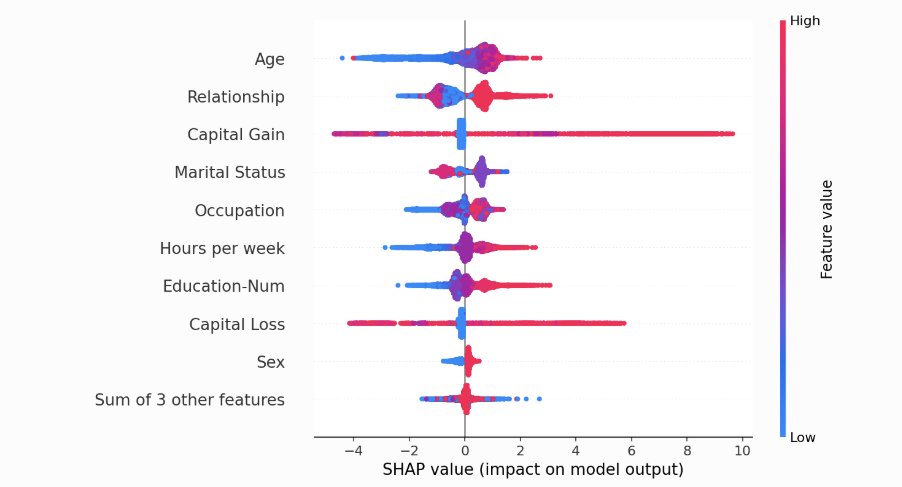

Red color -> high feature value

Blue color -> low feature value

SHAP value > 0 : Increases outcome

SHAP value < 0 : Decreases outcome

# Permutation importance for MLPClassifier

Task: Use permutation importance to identify which features are most impactful in predicting heart disease with an MLPClassifier.

X containing the features and y containing the labels have been pre-loaded for you. matplotlib.pyplot has been imported as plt.

In [27]:
pip install pandas scikit-learn numpy

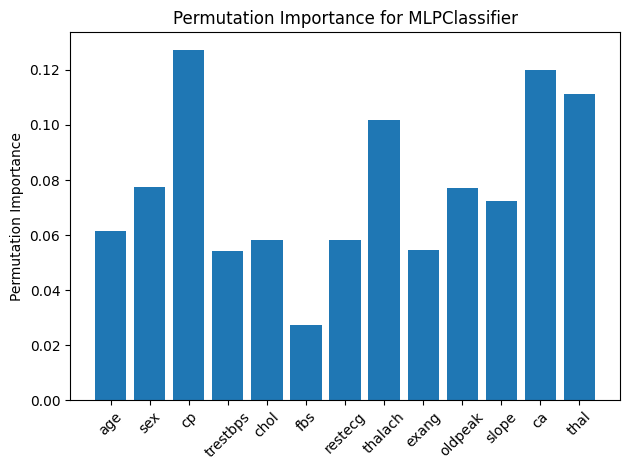

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
data = pd.read_csv("heart.csv")
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Define features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) # Convert back to DataFrame to keep column names for plotting

model = MLPClassifier(hidden_layer_sizes=(10), random_state=1, max_iter=1000)
model.fit(X_scaled, y)

# Compute the permutation importance
result = permutation_importance(model,X_scaled, y,n_repeats=10, random_state=1)

# Plot feature importances

plt.bar(X.columns, result.importances_mean)
plt.xticks(rotation=45)
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance for MLPClassifier')
plt.tight_layout()
plt.show()

This graph shows how permutation importance reveals that chest pain type is the most important factor in predicting heart disease for the MLPClassifier, consistent with the results you've seen before, highlighting the reliability of this feature across different models

# Compare Coefficients vs. permutation importance

Compute the coefficients of the logistic regression model.

Compute the permutation importance with 20 repeats using a random_state of 1.

Compute the average permutation importance across all repeats.



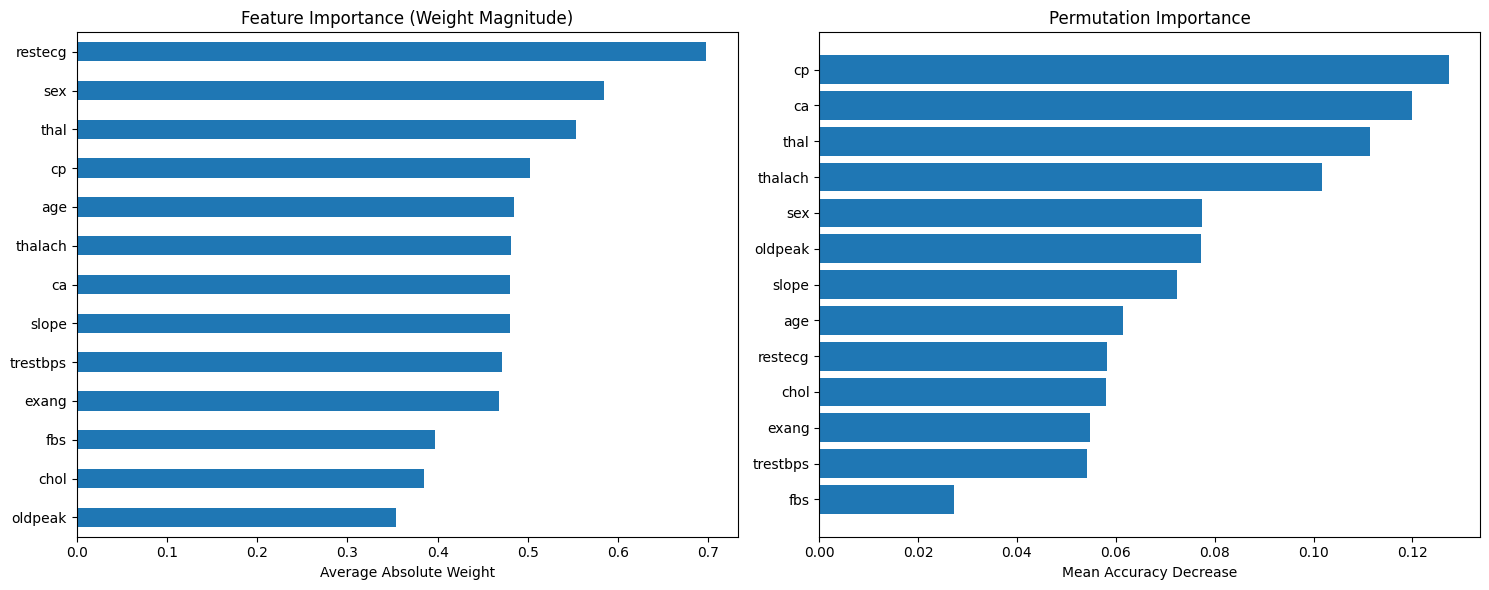

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("heart.csv")

# Define features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Train MLP model
model = MLPClassifier(hidden_layer_sizes=(10,), random_state=1, max_iter=1000)
model.fit(X_scaled, y)

# --- Key Fix: Use .coefs_ instead of .coef_ ---
# MLP coefficients are stored as a list (one per layer)
# For feature importance, we typically use the first layer's weights
first_layer_weights = model.coefs_[0]
feature_importance = pd.Series(abs(first_layer_weights).mean(axis=1), index=X.columns)

# Compute permutation importance
perm_importance = permutation_importance(model, X_scaled, y, n_repeats=10, random_state=1)

# Plot both importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Weight-based importance
feature_importance.sort_values().plot.barh(ax=ax1)
ax1.set_title('Feature Importance (Weight Magnitude)')
ax1.set_xlabel('Average Absolute Weight')

# Permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
ax2.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax2.set_title('Permutation Importance')
ax2.set_xlabel('Mean Accuracy Decrease')

plt.tight_layout()
plt.show()

 Even though there are differences between methods, both agree that chest pain type is the most influencial factor in predicting heart disease!



---



# SHAP (SHapley Additive exPlanations)

SHAP  is a method used in machine learning to explain the output of a model by attributing the contribution of each feature to a specific prediction. It's a unified approach to interpretability that draws on concepts from game theory, specifically Shapley values. Essentially, SHAP helps understand how each feature influences a model's prediction, both for individual instances (local explanations) and for the overall model behavior (global explanations).

Imagine you have a black box (like a video game console) that predicts something—like whether you’ll win a game or not. You know the inputs (your skill level, internet speed, controller quality), but you don’t know how much each one matters.

SHAP (SHapley Additive exPlanations) is like a fair referee that tells you:

✅ *"Your skill contributed +20% to winning."*
✅ *"Your slow internet reduced chances by -10%."*
✅ "Your controller had almost no effect."

How Does SHAP Work?
It plays "what if" games:

"What if we remove skill level? How much worse does the prediction get?"

"What if we only use internet speed?"

It combines all these tests to give each feature a fair score (called a SHAP value).

The scores add up to explain why the model made a prediction.



---



# Using SHAP on the Insurance Dataset

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the data
df = pd.read_csv('insurance.csv')

# Separate features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Define categorical and numerical features
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#Train a model that SHAP can explain

from sklearn.ensemble import RandomForestRegressor

# Create pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

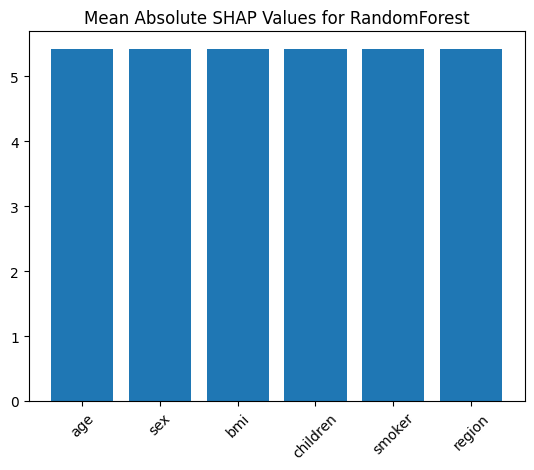

In [32]:
# Calculate SHAP Values

import shap

# Create a SHAP explainer
# First we need to get the transformed feature names
transformed_features = numerical_features.copy()
transformed_features.extend(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Create a TreeExplainer for the RandomForest model
explainer = shap.TreeExplainer(model.named_steps['regressor'])

# Get SHAP values for the test set
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)

# Calculate mean absolute SHAP values
mean_abs_shap = shap_values.mean()

plt.bar(X.columns, mean_abs_shap)
plt.title('Mean Absolute SHAP Values for RandomForest')
plt.xticks(rotation=45)
plt.show()

#Visualize SHAP Explanations

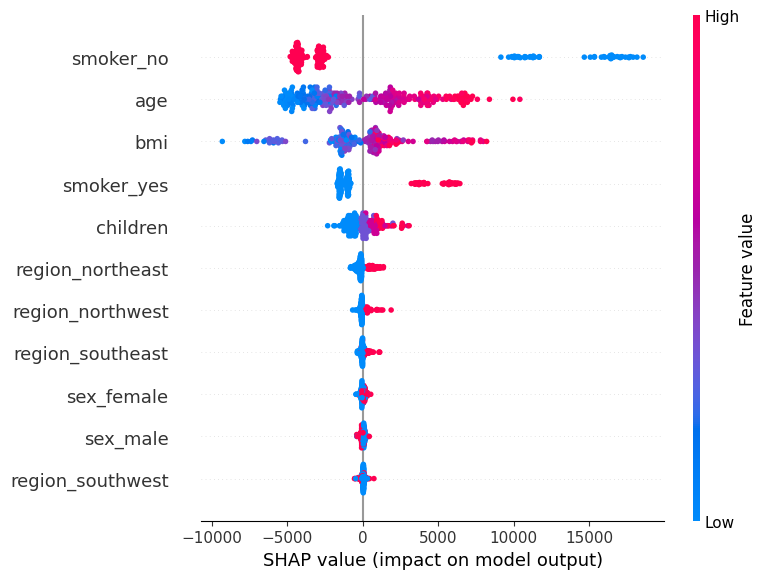

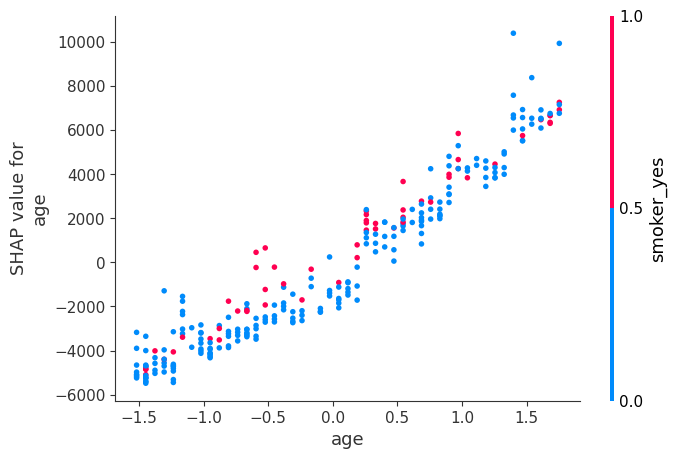

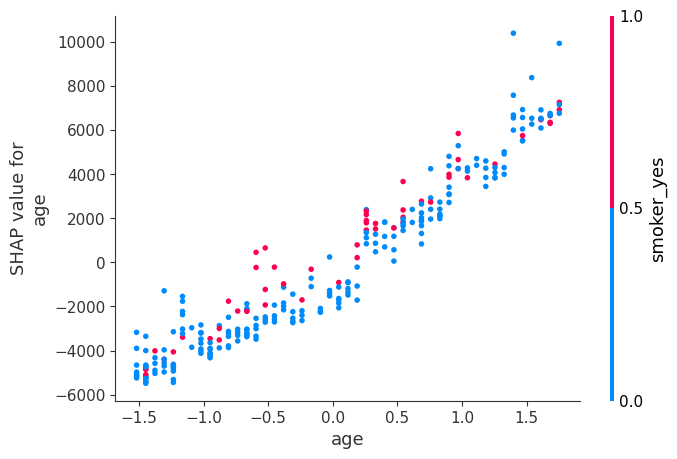

In [33]:
# Summary Plot (Feature Importance)
shap.summary_plot(shap_values, X_test_transformed, feature_names=transformed_features)

#Force Plot for Individual Predictions
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_transformed[0,:], feature_names=transformed_features)

# For age (the first feature)
shap.dependence_plot(0, shap_values, X_test_transformed, feature_names=transformed_features)

# For age (the first feature)
shap.dependence_plot(0, shap_values, X_test_transformed, feature_names=transformed_features)

# Interpretion of the Results
The SHAP analysis helps you understand:

Feature Importance: Which features (like smoker, age, bmi) have the biggest impact on insurance charges

Directionality: How each feature affects the prediction (e.g., higher age increases charges)

Interactions: How features interact (e.g., smoking combined with high BMI might have a multiplicative effect)

**Key Findings:**

Smoker status will likely be the most important feature, with smokers paying much higher premiums

Age will show a positive relationship with charges

BMI will probably show a threshold effect where higher BMIs increase charges

Region may show some geographic variations in pricing


---



### **SHAP Kernel Explainer**  

Imagine you have a **magic black box** (like a machine learning model) that predicts something—like how much your **health insurance** will cost. You put in details like your age, weight, whether you smoke, etc., and it gives you a price.  

But here’s the problem: **You don’t know why it gave you that price.**  

That’s where **SHAP (SHapley Additive exPlanations)** comes in. It’s like a detective that opens up the black box and tells you:  
- **Which factors mattered the most?** (e.g., smoking increases cost more than age)  
- **How much each factor contributed?** (e.g., being a smoker added $10,000, but being young saved you $2,000)  

### **What’s the Kernel Explainer?**  
The **Kernel Explainer** is like a **universal translator** for SHAP. It works with **any** machine learning model (not just fancy ones like Random Forests).  

#### **How It Works (Simple Version):**  
1. **Takes random samples** of your data (like asking "What if this person was older? What if they didn’t smoke?").  
2. **Compares predictions** to see how changing one feature (like age) affects the result.  
3. **Calculates "fair shares"** (Shapley values) for each feature—like splitting credit among players in a team game.  

### **Example: Predicting Insurance Cost**  
Let’s say the model predicts your insurance cost is **$5,000**. SHAP Kernel Explainer might break it down like this:  

| Feature | Effect on Cost |
|---------|----------------|
| **Smoker (Yes)** | +$3,000 (biggest impact!) |
| **Age (25)** | +$1,500 |
| **BMI (High)** | +$800 |
| **Region (Expensive area)** | +$500 |
| **Baseline (Avg. cost)** | -$800 (you get a discount for being healthy) |

**Total = $5,000**  

### **Why Use Kernel Explainer?**  
- **Works with any model** (even if it’s not a decision tree).  
- **Fairly assigns credit** to each feature (like dividing points in a game).  
- **Helps you trust the model** by showing why it made a decision.  

### **Downside?**  
- **Slower** than other SHAP methods (because it has to test many combinations).  
- **More math-heavy** behind the scenes (but you don’t need to worry about that to use it).  

### **Final Thought:**  
SHAP Kernel Explainer is like a **science fair judge**—it carefully checks how much each factor (age, smoking, etc.) contributes to the final prediction, so you **understand why the model thinks what it does**.  

# Building SHAP Kernel Explainers for MLPRegressor and MLPClassifier

**Part 1: Kernel Explainer for MLPRegressor (Predicting Insurance Charges)**


  0%|          | 0/100 [00:00<?, ?it/s]

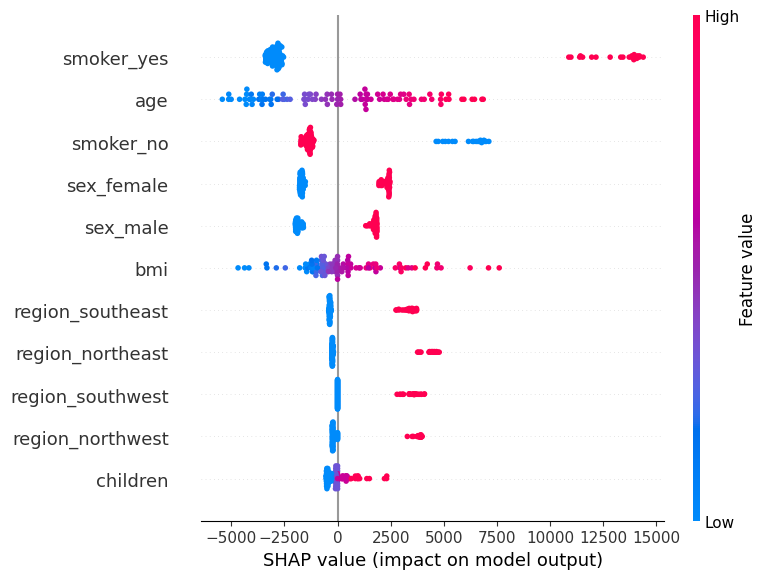

In [34]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


df = pd.read_csv('insurance.csv')

# Separate features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Define categorical and numerical features
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train MLPRegressor with better convergence settings
mlp_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(100, 50),
        max_iter=2000,  # Increased iterations
        early_stopping=True,  # Stop if validation score stops improving
        random_state=42,
        solver='adam',
        learning_rate_init=0.001
    ))
])

mlp_reg.fit(X_train, y_train)

# Create a prediction function that handles data properly
def model_predict(data):
    if isinstance(data, pd.DataFrame):
        return mlp_reg.predict(data)
    else:
        # Convert numpy array to DataFrame with correct column names
        return mlp_reg.predict(pd.DataFrame(data, columns=X.columns))

# Get transformed feature names
transformed_feature_names = numerical_features.copy()
transformer = mlp_reg.named_steps['preprocessor'].named_transformers_['cat']
transformed_feature_names.extend(transformer.get_feature_names_out(categorical_features))

# Create background data (using actual transformed data)
X_train_transformed = mlp_reg.named_steps['preprocessor'].transform(X_train)
background = shap.kmeans(X_train_transformed, 20)

# Create KernelExplainer with the transformed data
explainer_reg = shap.KernelExplainer(
    lambda x: mlp_reg.named_steps['regressor'].predict(x),
    background
)

# Calculate SHAP values
shap_values_reg = explainer_reg.shap_values(X_train_transformed[:100])

# Visualize
shap.summary_plot(shap_values_reg, X_train_transformed[:100],
                 feature_names=transformed_feature_names)

# Part 2: Kernel Explainer for MLPClassifier (Predicting Smoker Status)

Let's modify the problem to predict whether someone is a smoker (classification)

Model accuracy: 0.7425
Calculating SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

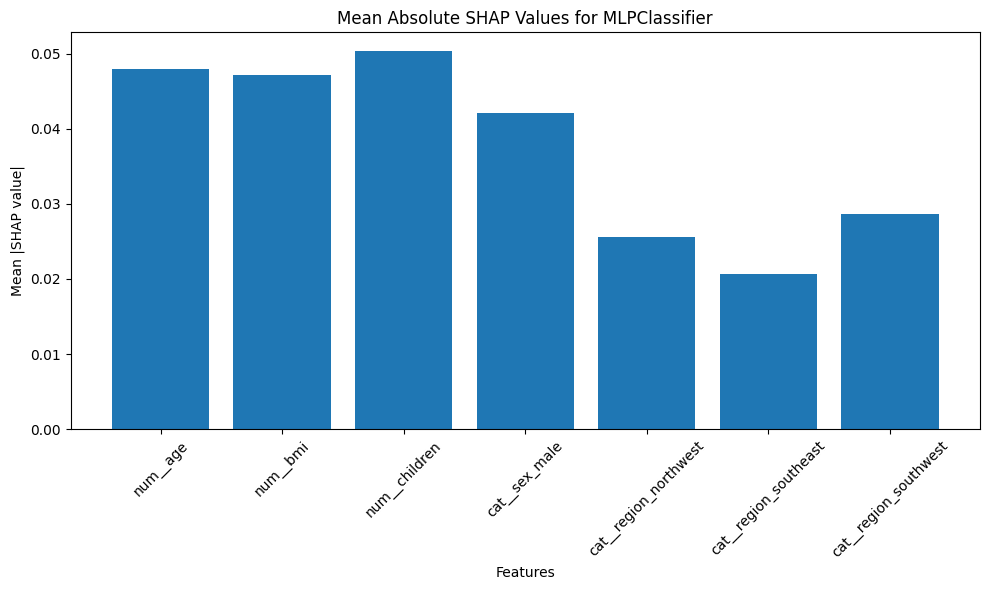

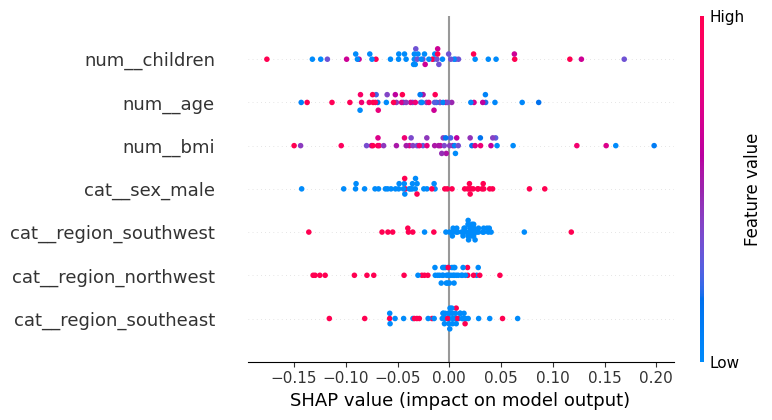

Most important feature: num__children
Expected value (baseline): 0.2025


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap


df = pd.read_csv('insurance.csv')
y = df['smoker'].map({'yes': 1, 'no': 0})
X = df.drop(['smoker', 'charges'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessor and model pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['age', 'bmi', 'children']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['sex', 'region'])
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
])

# Train model
model.fit(X_train, y_train)
print(f"Model accuracy: {model.score(X_test, y_test):.4f}")

# Transform data for SHAP
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Get feature names
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Create SHAP Kernel Explainer
# Use transformed data and classifier-only prediction function
def predict_proba_smoker(X_transformed):
    return model.named_steps['classifier'].predict_proba(X_transformed)[:, 1]

# Create background data (fix: convert DenseData to array)
background = shap.kmeans(X_train_transformed, 20)
if hasattr(background, 'data'):
    background = background.data

explainer = shap.KernelExplainer(predict_proba_smoker, background)

# Calculate SHAP values for subset of test data
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test_transformed[:50])

# Calculate mean absolute SHAP values
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)


plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), mean_abs_shap)
plt.title('Mean Absolute SHAP Values for MLPClassifier')
plt.xlabel('Features')
plt.ylabel('Mean |SHAP value|')
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.tight_layout()
plt.show()


shap.summary_plot(shap_values, X_test_transformed[:50], feature_names=feature_names)

print(f"Most important feature: {feature_names[np.argmax(mean_abs_shap)]}")
print(f"Expected value (baseline): {explainer.expected_value:.4f}")



---



# LIME Explainer for KNN Regressor Model



In [47]:
!pip install lime
import lime
import lime.lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ce2bac8564087dbe9225f9d1cf095d4237fa13d334380c6d865662c894f1325d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Available columns: ['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Chance of Admit']

Sample Index: 0
Actual Chance of Admit: 0.6800
Predicted Chance of Admit: 0.6820

Feature Importance:



Feature contributions:
CGPA <= -0.71: -0.0404
GRE Score <= -0.70: -0.0240
-1.08 < Research <= 0.93: 0.0096
-0.74 < TOEFL Score <= -0.07: -0.0057
-0.62 < Chance of Admit <= 0.03: 0.0016
0.06 < LOR <= 0.61: -0.0010
-0.85 < SOP <= 0.13: 0.0009
-0.93 < University Rating <= -0.06: 0.0006


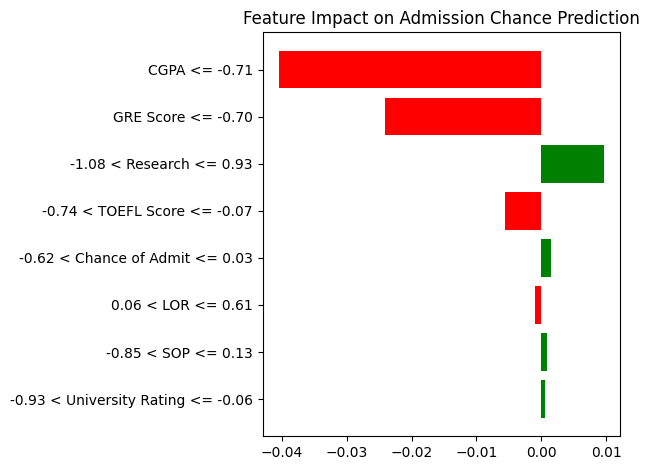

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from lime import lime_tabular
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('Admission_Predict.csv')

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Verify column names
print("Available columns:", data.columns.tolist())

# Drop Serial No. and split into features/target
X = data.drop(['Serial No.', 'Chance of Admit'], axis=1, errors='ignore')  # Handle potential typos
X = data.drop('Serial No.', axis=1)  # More precise if column exists

# Handle target column with flexible naming
target_col = 'Chance of Admit'  # Most common
if target_col not in data.columns:
    # Try common alternatives
    alternatives = ['Chance of Admit ', 'Chance_of_Admit', 'Admit Chance', 'Chance']
    for alt in alternatives:
        if alt in data.columns:
            target_col = alt
            break
    else:
        # If still not found, use last column as target
        target_col = data.columns[-1]

y = data[target_col]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Create LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns,
    class_names=['Admission Chance'],
    mode='regression',
    discretize_continuous=True
)

# Select a sample to explain
sample_idx = 0
sample_data_point = X_test_scaled[sample_idx]
actual_chance = y_test.iloc[sample_idx]

# Get model prediction
predicted_chance = knn.predict(sample_data_point.reshape(1, -1))[0]

# Generate explanation
exp = explainer.explain_instance(
    data_row=sample_data_point,
    predict_fn=knn.predict,
    num_features=len(X.columns)
)

# Display results
print(f"\nSample Index: {sample_idx}")
print(f"Actual Chance of Admit: {actual_chance:.4f}")
print(f"Predicted Chance of Admit: {predicted_chance:.4f}")
print("\nFeature Importance:")

# Show explanation in notebook (or save as HTML)
exp.show_in_notebook(show_table=True)

# Alternative text output
print("\nFeature contributions:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Plot feature weights
fig = exp.as_pyplot_figure()
plt.title("Feature Impact on Admission Chance Prediction")
plt.tight_layout()
plt.show()

# Save explanation to HTML
exp.save_to_file('lime_explanation.html')



---



# Explaining sentiment analysis predictions

You are provided with a model that classifies product reviews as expressing positive or negative sentiment.

Your task is to use LIME to identify which words in a given text_instance most influence the model's predictions.

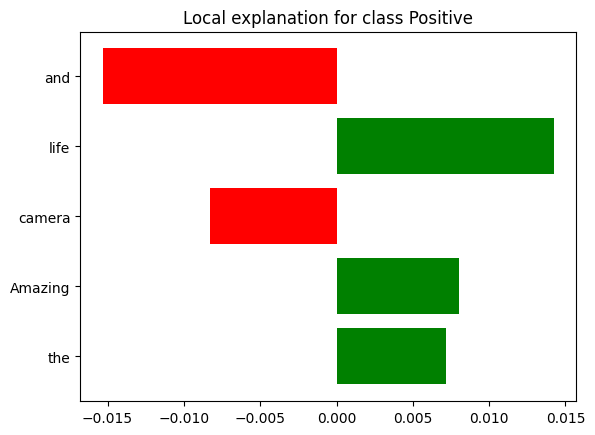

In [53]:
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

# Your model's prediction function must return probabilities for all classes
def model_predict(texts):
    # Replace with your actual model prediction
    # Must return shape (n_samples, n_classes)
    n = len(texts)
    # Example: binary classification probabilities
    probs = np.random.rand(n, 2)
    return probs / probs.sum(axis=1, keepdims=True)

text_instance = "Amazing battery life and the camera quality is perfect! I highly recommend this smartphone."
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
exp = explainer.explain_instance(text_instance, model_predict, num_features=5)
exp.as_pyplot_figure()
plt.show()

You have a model that classifies images, and your task is to use LIME to identify the regions the model mostly focuses on while making its prediction for the image below.

  0%|          | 0/50 [00:00<?, ?it/s]

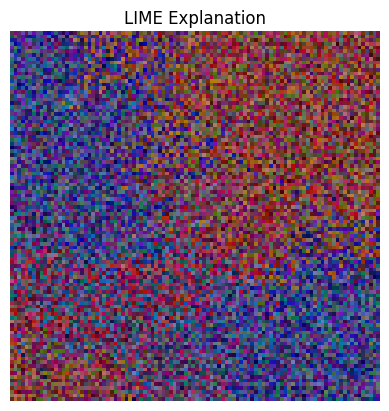

In [57]:
# Load your image data here into a variable named 'image'
# Example:
#from skimage.io import imread
#image = imread('your_image_path.jpg')

# Placeholder for image data - replace with your actual image loading code
# For demonstration, creating a dummy image array
image = np.random.rand(100, 100, 3) * 255
image = image.astype(np.uint8)

from lime import lime_image
np.random.seed(10)

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate the explanation
# Note: You might need to adjust num_samples based on image complexity and computation time
explanation = explainer.explain_instance(image, model_predict, hide_color=0, num_samples=50)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], hide_rest=False) # Set hide_rest=False to see highlighted regions
plt.imshow(temp / 255.0) # Normalize image data if needed for display
plt.imshow(mask, cmap='jet', alpha=0.5) # Overlay the mask
plt.title('LIME Explanation')
plt.axis('off')
plt.show()

# You can also get individual explanations
# for label in explanation.top_labels:
#     temp, mask = explanation.get_image_and_mask(label, hide_rest=False)
#     plt.imshow(temp / 255.0)
#     plt.imshow(mask, cmap='jet', alpha=0.5)
#     plt.title(f'LIME Explanation for class {label}')
#     plt.axis('off')
#     plt.show()